In [ ]:
# !pip install transformers

In [1]:
import os, gc, sys, time, collections, random
import numpy as np
import pandas as pd

from typing import Dict, Optional, Union, Any, List, Tuple

from pathlib import Path
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold

import torch
import torch.nn as nn

import torch.utils.data as D
from torch.utils.data.dataset import Dataset, IterableDataset
from torch.utils.data.dataloader import DataLoader

from transformers import DistilBertTokenizerFast
from transformers import DistilBertModel
from transformers import BertTokenizerFast
from transformers import BertModel
from transformers import Trainer
from transformers import AutoModel, AutoTokenizer, AutoConfig, AutoModelForSequenceClassification
from transformers.data.processors.utils import InputFeatures
from transformers import TrainingArguments
from transformers.trainer_utils import EvalLoopOutput
from transformers.trainer import logging
from transformers.file_utils import is_torch_tpu_available, is_sagemaker_mp_enabled
from transformers.trainer_pt_utils import find_batch_size, nested_concat, nested_numpify, nested_truncate, nested_detach

### Folders and Dataframes

In [2]:
DATA_PATH = Path('/home/commonlit/data/')
assert DATA_PATH.exists()
MODELS_PATH = Path('/home/commonlit/models/')
if not MODELS_PATH.exists():
    os.mkdir(MODELS_PATH)
assert MODELS_PATH.exists()

In [3]:
!ls {DATA_PATH}

01_data_enhancements.ipynb     extra_data	      train-mix.csv
02_synonymizer.ipynb	       sample_submission.csv  train-orig.csv
commonlit_lm		       test-enhanced.csv      train.csv
commonlit_lm.zip	       test.csv		      train_duo.csv
commonlitreadabilityprize.zip  thumbelina	      train_enhancements.csv


In [4]:
train_df = pd.read_csv(DATA_PATH/'train-orig.csv')
test_df = pd.read_csv(DATA_PATH/'test.csv')
sample_df = pd.read_csv(DATA_PATH/'sample_submission.csv')

In [5]:
train_df

,id,url_legal,license,excerpt,target,standard_error
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845
...,...,...,...,...,...,...
2829,25ca8f498,https://sites.ehe.osu.edu/beyondpenguins/files...,CC BY-SA 3.0,When you think of dinosaurs and where they liv...,1.711390,0.646900
2830,2c26db523,https://en.wikibooks.org/wiki/Wikijunior:The_E...,CC BY-SA 3.0,So what is a solid? Solids are usually hard be...,0.189476,0.535648
2831,cd19e2350,https://en.wikibooks.org/wiki/Wikijunior:The_E...,CC BY-SA 3.0,The second state of matter we will discuss is ...,0.255209,0.483866
2832,15e2e9e7a,https://en.wikibooks.org/wiki/Geometry_for_Ele...,CC BY-SA 3.0,Solids are shapes that you can actually touch....,-0.215279,0.514128


In [6]:
train_df[train_df['excerpt'].str.contains('Robin Hood')]

,id,url_legal,license,excerpt,target,standard_error
222,21ea485fb,NaN,NaN,A little within the wood there was a fair cast...,-1.302688,0.450399
223,a04741371,NaN,NaN,"The king dwelt for many months in Nottingham, ...",-0.714009,0.506864
224,5cb5ab998,NaN,NaN,"When they drew near Nottingham, all the people...",-1.541347,0.478166
225,622f6215e,NaN,NaN,About this time there was living in Nottingham...,-2.054284,0.538084


In [7]:
train_df[train_df['id'] == '21ea485fb']['excerpt'].values

array(['A little within the wood there was a fair castle, with a double moat, and surrounded by stout walls. Here dwelt that noble knight, Sir Richard Lee, to whom Robin Hood had lent the four hundred pounds to redeem his land.\nHe saw the little company of outlaws fighting their way along, so he hastened to call them to come and take shelter in his castle.\n"Welcome art thou, Robin Hood! Welcome!" he cried, as he led them in. "Much I thank thee for thy comfort and courtesy and great kindness to me in the forest. There is no man in the world I love so much as thee. For all the proud Sheriff of Nottingham, here thou shalt be safe!—Shut the gates, and draw the bridge, and let no man come in!" he shouted to his retainers. "Arm you well; make ready; guard the walls! One thing, Robin, I promise thee: here shalt thou stay for twelve days as my guest, to sup, and eat, and dine."\nSwiftly and readily tables were laid and cloths spread, and Robin Hood and his merry men sat down to a good meal.'

In [8]:
train_df[train_df['id'] == '0bf29d257']['target']

1290   -3.351956
Name: target, dtype: float64

### Normalize

In [9]:
train_df['target'].describe()

count    2834.000000
mean       -0.959319
std         1.033579
min        -3.676268
25%        -1.690320
50%        -0.912190
75%        -0.202540
max         1.711390
Name: target, dtype: float64

In [10]:
train_target_mean = train_df['target'].mean()
train_target_std = train_df['target'].std()
train_df['normalized_target'] = (train_df['target'] - train_target_mean) / train_target_std

In [11]:
train_target_mean, train_target_std

(-0.9593187699947071, 1.0335792017597232)

In [12]:
train_df['normalized_target'].describe()

count    2.834000e+03
mean    -1.002883e-17
std      1.000000e+00
min     -2.628680e+00
25%     -7.072520e-01
50%      4.559799e-02
75%      7.321924e-01
max      2.583942e+00
Name: normalized_target, dtype: float64

In [13]:
train_df['normalized_target_check'] = train_df['normalized_target'] * train_target_std + train_target_mean

In [14]:
train_df.head(30)

,id,url_legal,license,excerpt,target,standard_error,normalized_target,normalized_target_check
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009,0.598947,-0.340259
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805,0.623026,-0.315372
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676,0.366881,-0.580118
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007,-0.091618,-1.054013
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845,1.167319,0.247197
5,f9bf357fe,NaN,NaN,Hal and Chester found ample time to take an in...,-0.861809,0.480936,0.094342,-0.861809
6,eaf8e7355,NaN,NaN,Hal Paine and Chester Crawford were typical Am...,-1.759061,0.476507,-0.773760,-1.759061
7,0a43a07f1,NaN,NaN,"On the twenty-second of February, 1916, an aut...",-0.952325,0.498116,0.006767,-0.952325
8,f7eff7419,NaN,NaN,The boys left the capitol and made their way d...,-0.371641,0.463710,0.568585,-0.371641
9,d96e6dbcd,NaN,NaN,One day he had gone beyond any point which he ...,-1.238432,0.465900,-0.270046,-1.238432


In [15]:
# !pip install seaborn

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='normalized_target'>

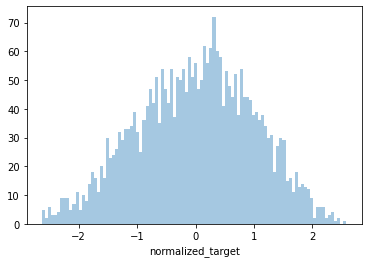

In [17]:
sns.distplot(train_df['normalized_target'],bins=100,kde=False)

### Configuration

In [18]:
import yaml

In [19]:
class CONFIG():
    batch_size = 24
    max_len = 256
    num_workers = 4
    epochs = 20
    pretrained_transformers_model = f'/home/commonlit/models/roberta-base_lm'
    target_field = 'normalized_target'
    patience = 15

In [20]:
cfg = CONFIG()
cfg.model_name = 'roberta-base'
cfg.num_folds = 6

In [21]:
cfg.train_target_std = float(train_target_std)
cfg.train_target_mean = float(train_target_mean)

In [22]:
# assert Path(cfg.pretrained_transformers_model).exists()

In [23]:
vars(cfg)

{'model_name': 'roberta-base',
 'num_folds': 6,
 'train_target_std': 1.0335792017597232,
 'train_target_mean': -0.9593187699947071}

In [24]:
with open(f'{MODELS_PATH}/{cfg.model_name}.yaml', 'w') as file:
    documents = yaml.dump(vars(cfg), file)

### Prepare Cross Validation

In [25]:
target = train_df[cfg.target_field].to_numpy()

In [26]:
# num_bins = int(np.floor(np.log2(len(train_df))) + 1)
# train_df.loc[:, 'bins'] = pd.cut(train_df[cfg.target_field], bins=num_bins, labels=False)

In [27]:
def add_bins(train_df, target_field=cfg.target_field):
    num_bins = int(np.floor(np.log2(len(train_df))) + 1)
    train_df.loc[:, 'bins'] = pd.cut(train_df[target_field], bins=num_bins, labels=False)
    return num_bins

In [28]:
num_bins = add_bins(train_df)

In [29]:
train_df[[cfg.target_field, 'bins']].groupby(['bins']).agg(['mean', 'count'])

normalized_target      
                  mean count
bins                        
0            -2.374059    43
1            -1.944747    79
2            -1.516352   172
3            -1.109808   269
4            -0.670880   366
5            -0.234315   418
6             0.203739   481
7             0.628417   405
8             1.053944   312
9             1.470353   183
10            1.875271    83
11            2.282440    23

In [30]:
kf = StratifiedKFold(n_splits=cfg.num_folds)

In [31]:
def add_kfold(train_df):
    for i, (t_, v_) in enumerate(kf.split(X=train_df, y=train_df.bins.values)):
        train_df.loc[v_, 'kfold'] = i

In [32]:
add_kfold(train_df)

In [33]:
train_df['kfold'] = train_df['kfold'].astype(np.uint8)

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='target'>

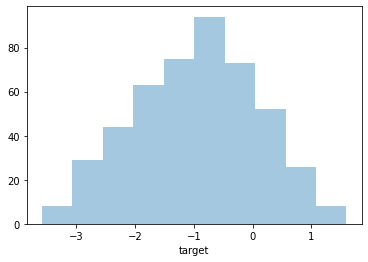

In [34]:
sns.distplot(train_df[train_df['kfold'] == 2]['target'],bins=10,kde=False)


In [35]:
# train_df = train_df.drop('bins', axis=1)

In [36]:
train_df

,id,url_legal,license,excerpt,target,standard_error,normalized_target,normalized_target_check,bins,kfold
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009,0.598947,-0.340259,7,0
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805,0.623026,-0.315372,7,0
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676,0.366881,-0.580118,6,0
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007,-0.091618,-1.054013,5,0
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845,1.167319,0.247197,8,0
...,...,...,...,...,...,...,...,...,...,...
2829,25ca8f498,https://sites.ehe.osu.edu/beyondpenguins/files...,CC BY-SA 3.0,When you think of dinosaurs and where they liv...,1.711390,0.646900,2.583942,1.711390,11,5
2830,2c26db523,https://en.wikibooks.org/wiki/Wikijunior:The_E...,CC BY-SA 3.0,So what is a solid? Solids are usually hard be...,0.189476,0.535648,1.111472,0.189476,8,5
2831,cd19e2350,https://en.wikibooks.org/wiki/Wikijunior:The_E...,CC BY-SA 3.0,The second state of matter we will discuss is ...,0.255209,0.483866,1.175070,0.255209,8,5
2832,15e2e9e7a,https://en.wikibooks.org/wiki/Geometry_for_Ele...,CC BY-SA 3.0,Solids are shapes that you can actually touch....,-0.215279,0.514128,0.719867,-0.215279,7,5


In [37]:
train_df[[cfg.target_field, 'kfold']].groupby(['kfold']).agg(['mean', 'count'])

normalized_target      
                   mean count
kfold                        
0              0.004119   473
1              0.011312   473
2              0.001834   472
3             -0.011148   472
4             -0.000436   472
5             -0.005713   472

In [38]:
train_df

,id,url_legal,license,excerpt,target,standard_error,normalized_target,normalized_target_check,bins,kfold
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009,0.598947,-0.340259,7,0
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805,0.623026,-0.315372,7,0
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676,0.366881,-0.580118,6,0
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007,-0.091618,-1.054013,5,0
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845,1.167319,0.247197,8,0
...,...,...,...,...,...,...,...,...,...,...
2829,25ca8f498,https://sites.ehe.osu.edu/beyondpenguins/files...,CC BY-SA 3.0,When you think of dinosaurs and where they liv...,1.711390,0.646900,2.583942,1.711390,11,5
2830,2c26db523,https://en.wikibooks.org/wiki/Wikijunior:The_E...,CC BY-SA 3.0,So what is a solid? Solids are usually hard be...,0.189476,0.535648,1.111472,0.189476,8,5
2831,cd19e2350,https://en.wikibooks.org/wiki/Wikijunior:The_E...,CC BY-SA 3.0,The second state of matter we will discuss is ...,0.255209,0.483866,1.175070,0.255209,8,5
2832,15e2e9e7a,https://en.wikibooks.org/wiki/Geometry_for_Ele...,CC BY-SA 3.0,Solids are shapes that you can actually touch....,-0.215279,0.514128,0.719867,-0.215279,7,5


/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='normalized_target'>

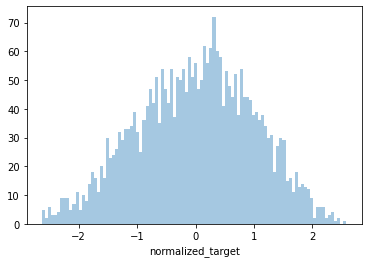

In [39]:
sns.distplot(train_df['normalized_target'],bins=100,kde=False)

In [40]:
bin_list = list(range(num_bins))
random.shuffle(bin_list)
bin_list

[11, 7, 4, 9, 0, 3, 1, 2, 8, 10, 6, 5]

In [41]:
train_df['normalized_target'].mean()

-1.0028831838533525e-17

### Metrics

In [42]:
def rmse_score(y_true, y_pred):
    return np.sqrt(np.mean((y_pred - y_true) ** 2))

def rmse_score_2(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [43]:
a = np.random.rand(10)
b = np.random.rand(10)

In [44]:
rmse_score(a, b), rmse_score_2(a, b)

(0.3280900226119872, 0.3280900226119872)

### Prepare train test split

In [45]:
def create_split(fold = [1], target_field=cfg.target_field):
    valid_df = train_df[train_df['kfold'].isin(fold)]
    valid_text = valid_df['excerpt'].values
    valid_target = valid_df[target_field].values
    training_df = train_df[~train_df['kfold'].isin(fold)]
    train_text = training_df['excerpt'].values
    train_target = training_df[target_field].values
    train_bins = training_df['bins'].to_numpy()
    return train_bins, train_text, train_target, valid_text, valid_target

In [46]:
train_bins, train_text, train_target, valid_text, valid_target = create_split([0])
len(train_text), len(valid_text)

(2361, 473)

### Prepare Tokenizers

In [47]:
tokenizer = AutoTokenizer.from_pretrained(cfg.pretrained_transformers_model)
# Save the tokenizer so that you can download the files and move it to a Kaggle dataset.
# tokenizer.save_pretrained(cfg.save_dir)

In [48]:
encoded_dict = tokenizer(train_df['excerpt'].values[0],
                                return_tensors='pt',
                                max_length=cfg.max_len,
                                padding='max_length',
                                truncation=True,
                                return_token_type_ids=True)
decoded = tokenizer.decode(encoded_dict["input_ids"].squeeze())
decoded

'<s>When the young people returned to the ballroom, it presented a decidedly changed appearance. Instead of an interior scene, it was a winter landscape.\nThe floor was covered with snow-white canvas, not laid on smoothly, but rumpled over bumps and hillocks, like a real snow field. The numerous palms and evergreens that had decorated the room, were powdered with flour and strewn with tufts of cotton, like snow. Also diamond dust had been lightly sprinkled on them, and glittering crystal icicles hung from the branches.\nAt each end of the room, on the wall, hung a beautiful bear-skin rug.\nThese rugs were for prizes, one for the girls and one for the boys. And this was the game.\nThe girls were gathered at one end of the room and the boys at the other, and one end was called the North Pole, and the other the South Pole. Each player was given a small flag which they were to plant on reaching the Pole.\nThis would have been an easy matter, but each traveller was obliged to wear snowshoes

In [49]:
encoded_dict.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [50]:
encoded_dict.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [51]:
encoded_dict['input_ids'].shape

torch.Size([1, 256])

In [52]:
def convert_to_list(t):
    return t.flatten().long()

class CommonLitDataset(nn.Module):
    def __init__(self, text, target, tokenizer, bins=None, max_len=128):
        self.excerpt = text
        self.target = target
        self.bins = bins
        self.max_len = max_len
        self.tokenizer = tokenizer
    
    def __getitem__(self, idx):
        encode = self.tokenizer(self.excerpt[idx],
                                return_tensors='pt',
                                max_length=self.max_len,
                                padding='max_length',
                                truncation=True)
#         input_features = InputFeatures(input_ids=convert_to_list(encode['input_ids']),
#                               attention_mask=convert_to_list(encode['attention_mask']),
#                               label=torch.tensor(self.target[idx]))
        input_features = {
            'input_ids': convert_to_list(encode['input_ids']),
            'attention_mask': convert_to_list(encode['attention_mask']),
            'labels': torch.tensor(self.target[idx]),
            'bins': self.bins
        }
        return input_features
    
    def __len__(self):
        return len(self.excerpt)

In [53]:
def create_train_valid_ds(tokenizer, train_text, train_target, bins, valid_text, valid_target):
    train_ds = CommonLitDataset(train_text, train_target, tokenizer, bins, cfg.max_len)
    valid_ds = CommonLitDataset(valid_text, valid_target, tokenizer, None, cfg.max_len)
    return train_ds, valid_ds

In [54]:
# encode['input_ids'][0].squeeze()

### Model

In [55]:
# You can use a Transformer model of your choice.
# transformer_model = DistilBertModel.from_pretrained(cfg.pretrained_transformers_model)
transformer_model = AutoModel.from_pretrained(cfg.pretrained_transformers_model)

Some weights of the model checkpoint at /home/commonlit/models/roberta-base_lm were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /home/commonlit/models/roberta-base_lm and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a

In [56]:
# dict(transformer_out)['last_hidden_state'].shape

In [57]:
# torch.mean(transformer_out.last_hidden_state, axis=1).shape

In [58]:
# sample_layer = nn.Linear(768, 1)

In [59]:
model_config = AutoConfig.from_pretrained(cfg.pretrained_transformers_model)

In [60]:
model_config

RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.7.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

In [61]:
from torch.nn import functional as F

In [62]:
class ModelHead(nn.Module):
    def __init__(self, config, factor=1):
        super(ModelHead, self).__init__()
        self.layer_norm = nn.LayerNorm(config.hidden_size * factor)
        self.drop = nn.Dropout(0.3)
        self.use_linear = True
        self.out = nn.Linear(config.hidden_size * factor, 1)
        self._init_weights(self.layer_norm)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        if isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.drop(x)
        if self.use_linear:
            x = self.out(x)
        return x

In [63]:
from transformers import PreTrainedModel

class CommonLitModel(PreTrainedModel):
    def __init__(self):
        super(PreTrainedModel, self).__init__()
        self.transformer_model = AutoModel.from_pretrained(cfg.pretrained_transformers_model)
        self.config = AutoConfig.from_pretrained(cfg.pretrained_transformers_model)
        self.model_head = ModelHead(self.config)
        
    def forward(self, input_ids, attention_mask):
        transformer_out = self.transformer_model(input_ids=input_ids, attention_mask=attention_mask, 
                                                 output_hidden_states=False)
        x = transformer_out.pooler_output
#         x = transformer_out.last_hidden_state[:, 0, :] # N, C, X
#         x = torch.mean(transformer_out.hidden_states[-2], axis=1)
#         x2 = torch.mean(transformer_out.encoder_hidden_states[-2], axis=1)
#         x = torch.cat([x, x2], axis=1)
        return self.model_head(x)
    
    def floating_point_ops(self, inputs: Dict[str, Union[torch.Tensor, Any]]):
        """
        For models that inherit from :class:`~transformers.PreTrainedModel`, uses that method to compute the number of
        floating point operations for every backward + forward pass. If using another model, either implement such a
        method in the model or subclass and override this method.
        Args:
            inputs (:obj:`Dict[str, Union[torch.Tensor, Any]]`):
                The inputs and targets of the model.
        Returns:
            :obj:`int`: The number of floating-point operations.
        """
        return 0

In [64]:
model = CommonLitModel()

Some weights of the model checkpoint at /home/commonlit/models/roberta-base_lm were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /home/commonlit/models/roberta-base_lm and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a

In [65]:
encoded_dict.input_ids.shape

torch.Size([1, 256])

In [66]:
sample_res = model(input_ids=encoded_dict.input_ids, attention_mask=encoded_dict.attention_mask)

In [67]:
sample_res.shape

torch.Size([1, 1])

In [68]:
encoded_dict.token_type_ids.shape

torch.Size([1, 256])

In [69]:
transformer_model = transformer_model.cuda()
sample_out = transformer_model(encoded_dict.input_ids.cuda(), encoded_dict.attention_mask.cuda(), encoded_dict.token_type_ids.cuda(), output_hidden_states=True)

In [70]:
sample_out.keys()

odict_keys(['last_hidden_state', 'pooler_output', 'hidden_states'])

In [71]:
sample_out[2][-1].shape

torch.Size([1, 256, 768])

In [72]:
model.cpu().model_head(sample_out[1].cpu())

tensor([[-0.3356]], grad_fn=<AddmmBackward>)

In [73]:
sample_x = torch.mean(sample_out.hidden_states[-1], axis=1)

In [74]:
torch.cat([sample_x, sample_x], axis=1).shape

torch.Size([1, 1536])

In [75]:
sample_out.hidden_states[-1].shape, sample_out.hidden_states[-1][:, 0, :].shape

(torch.Size([1, 256, 768]), torch.Size([1, 768]))

In [76]:
train_ds, valid_ds = create_train_valid_ds(tokenizer, train_text, train_target, train_bins, valid_text, valid_target)

In [77]:
encode = train_ds[0]

In [78]:
encode['attention_mask'].unsqueeze(0).shape, encoded_dict['input_ids'].shape

(torch.Size([1, 256]), torch.Size([1, 256]))

In [79]:
sample_out = transformer_model(encode['input_ids'].unsqueeze(0).cuda(), encode['attention_mask'].unsqueeze(0).cuda())

### Sampling

In [80]:
from torch.utils.data import Sampler,SequentialSampler,RandomSampler,SubsetRandomSampler
from collections import Counter

class WeightedSampler(Sampler):
    
    def __init__(self, dataset):
        
        self.indices = list(range(len(dataset)))
        self.num_samples = len(dataset)
        self.label_to_count = dict(Counter(dataset.bins))
        weights = [1/self.label_to_count[i] for i in dataset.bins]
        
        self.weights = torch.tensor(weights,dtype=torch.double)
        
    def __iter__(self):
        count = 0
        index = [self.indices[i] for i in torch.multinomial(self.weights, self.num_samples, replacement=True)]
        while count < self.num_samples:
            yield index[count]
            count += 1
    
    def __len__(self):
        return self.num_samples

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

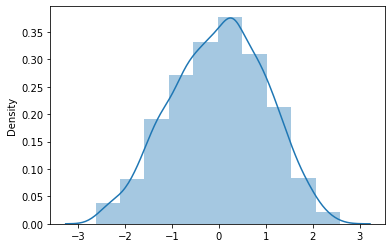

In [129]:
sns.distplot(train_ds.target, bins=10, kde=True)

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

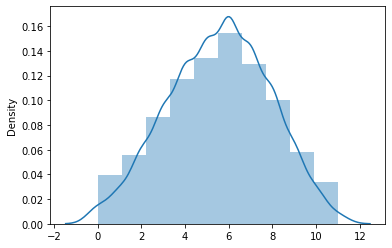

In [130]:
sns.distplot(train_ds.bins, bins=10, kde=True)

In [139]:
def plot_distribution(dl, field='labels', bins=10):
    all_labels = []
    for batch in dl:
        all_labels.extend(list(batch[field].numpy()))
    sns.distplot(all_labels, bins=bins, kde=True)
    print(np.array(all_labels).mean(), np.array(all_labels).std())

0.019212632434161523 1.4809009233051318


/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


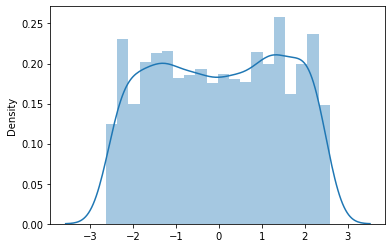

In [140]:
plot_distribution(DataLoader(train_ds, sampler = WeightedSampler(train_ds), batch_size=32, drop_last=False), bins=20)

-0.0008252549140683052 1.0024510684321637


/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


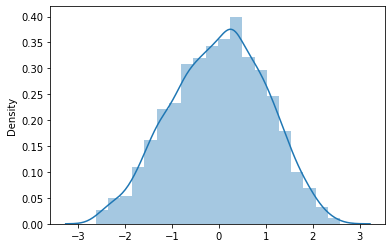

In [141]:
plot_distribution(DataLoader(train_ds, sampler = SequentialSampler(train_ds), batch_size=32, drop_last=False), bins=20)

-0.0008252549140682826 1.0024510684321637


/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


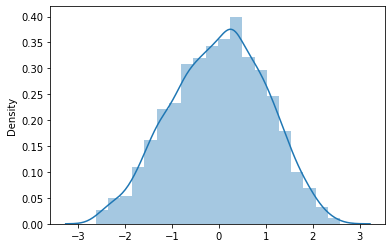

In [142]:
plot_distribution(DataLoader(train_ds, sampler = RandomSampler(train_ds), batch_size=32, drop_last=False), bins=20)

### Training

In [143]:
import os
os.environ['WANDB_DISABLED'] = "true"

In [144]:
criterion = nn.MSELoss()

kl_loss = nn.KLDivLoss(reduction = 'batchmean')

def loss_fct(yhat, y):
    return criterion(yhat, y) * 0.7 + 0.3 * kl_loss(yhat, y)

loss_fct = nn.MSELoss()

def loss_fct(yhat, y):
    return torch.sqrt(criterion(yhat, y))

In [145]:
# {'learning_rate': 3.737865823546993e-05, 'num_train_epochs': 16, 'seed': 39, 'per_device_train_batch_size': 8}

In [146]:
def create_training_args(fold):
    training_args = TrainingArguments(
        output_dir=str(MODELS_PATH/f"{cfg.model_name.replace('/', '_')}-{fold}"),
        overwrite_output_dir=True,
        do_train=True,
        do_eval=True,
        per_device_train_batch_size=cfg.batch_size,
        per_device_eval_batch_size=cfg.batch_size,
        num_train_epochs=cfg.epochs,
        logging_strategy="epoch",
        logging_first_step=True,
        save_steps=40000,
        fp16=True,
        evaluation_strategy="epoch",
        save_total_limit = 3,
        load_best_model_at_end=True,
        metric_for_best_model='rmse',
        greater_is_better=False,
        gradient_accumulation_steps=1,
        learning_rate=3e-05,
        report_to=None,
        seed=39
    )
    return training_args

In [147]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    return {'rmse': rmse_score_2(logits, labels)}

In [148]:
def model_init():
    return CommonLitModel()

In [149]:
tokenizer = AutoTokenizer.from_pretrained(cfg.pretrained_transformers_model)

In [150]:
logger = logging.get_logger(__name__)

class CommonLitTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        input_ids = inputs.pop("input_ids")
        attention_mask = inputs.pop("attention_mask")
        outputs = model(input_ids, attention_mask)
        logits = outputs
        loss = loss_fct(logits.flatten(),
                        labels.float().flatten())
        zero_cat = torch.zeros([1, 1]).to(outputs.device)
        return (loss, torch.cat([zero_cat, outputs])) if return_outputs else loss
    
    def get_train_dataloader(self) -> DataLoader:
        """
        Returns the training :class:`~torch.utils.data.DataLoader`.

        Will use no sampler if :obj:`self.train_dataset` does not implement :obj:`__len__`, a random sampler (adapted
        to distributed training if necessary) otherwise.

        Subclass and override this method if you want to inject some custom behavior.
        """
        if self.train_dataset is None:
            raise ValueError("Trainer: training requires a train_dataset.")

        train_dataset = self.train_dataset
        train_sampler = SequentialSampler(train_dataset)
        return DataLoader(train_dataset, sampler = train_sampler,
                                      batch_size=self.args.train_batch_size,
                                      drop_last=self.args.dataloader_drop_last,
                                      num_workers=self.args.dataloader_num_workers,
                                      pin_memory=self.args.dataloader_pin_memory)

In [151]:
!echo /home/commonlit/models/{cfg.model_name.replace('/', '_')}-*

/home/commonlit/models/roberta-base-0


In [152]:
!rm -rf /home/commonlit/models/{cfg.model_name.replace('/', '_')}-*

### Actual training

In [153]:
def gen_model(i = -1):
    if i == -1:
        return CommonLitModel()
    else:
        inference_model = CommonLitModel()
        inference_model = inference_model.cuda()
        inference_model.load_state_dict(torch.load(str(MODELS_PATH/f"{cfg.model_name.replace('/', '_')}-{i}/pytorch_model.bin")))
        inference_model.eval();
        return inference_model

In [154]:
def gen_model_init(i = -1):
    return gen_model(-1)

In [155]:
from transformers import EarlyStoppingCallback

def create_trainer(fold, gen_model=gen_model_init, learning_rate=None, target_field=cfg.target_field):
    bin_step = 1
    train_bins = bin_list[fold:fold + bin_step]
    print('train_bins', f'{fold}: {train_bins}')
    tokenizer = AutoTokenizer.from_pretrained(cfg.pretrained_transformers_model)
    bins, train_text, train_target, valid_text, valid_target = create_split([fold], target_field=target_field)
    train_ds, valid_ds = create_train_valid_ds(tokenizer, train_text, train_target, bins, valid_text, valid_target)
    training_args = create_training_args(fold)
    if learning_rate is not None:
        training_args.learning_rate = learning_rate
    model = gen_model(fold)
    return CommonLitTrainer(
            model=model,
            args=training_args,
            train_dataset=train_ds,
            eval_dataset=valid_ds,
            compute_metrics=compute_metrics,
            callbacks=[EarlyStoppingCallback(early_stopping_patience=cfg.patience)]
        ), training_args

In [156]:
sample_trainer, training_args = create_trainer(0)

Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


train_bins 0: [11]


Some weights of the model checkpoint at /home/commonlit/models/roberta-base_lm were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /home/commonlit/models/roberta-base_lm and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a

In [157]:
sample_trainer._get_train_sampler()

In [158]:
def gen_model_improve(i):
    return gen_model(i)

def do_train(gen_model=gen_model_init, learning_rate=None, target_field=cfg.target_field):
    bin_step = 1
    bestmodels = []
    eval_rmses = []
    for fold in range(0, cfg.num_folds, bin_step):
        trainer, training_args = create_trainer(fold, gen_model, learning_rate, target_field)
        trainer.train()
        trainer.save_model()
        print('training_args.output_dir', training_args.output_dir)
        tokenizer.save_pretrained(training_args.output_dir)
        result = trainer.evaluate()
        bestmodels.append(trainer.state.best_model_checkpoint)
        print('best_model_checkpoint', trainer.state.best_model_checkpoint)
        print('result', result)
        eval_rmses.append(result['eval_rmse'])
    return eval_rmses, bestmodels

In [159]:
%%time
        
eval_rmses, bestmodels = do_train()

Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


train_bins 0: [11]


Some weights of the model checkpoint at /home/commonlit/models/roberta-base_lm were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /home/commonlit/models/roberta-base_lm and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a

Epoch,Training Loss,Validation Loss,Rmse
1,0.982500,0.762553,0.782550
2,0.640200,0.931925,0.945018
3,0.550200,0.875821,0.884451
4,0.449100,0.799432,0.812026
5,0.407600,0.892258,0.906285
6,0.386600,0.870360,0.880094
7,0.378100,0.701751,0.721208
8,0.324800,0.713949,0.728784
9,0.384300,0.672515,0.699084
10,0.323700,0.648678,0.664850


training_args.output_dir /home/commonlit/models/roberta-base-0


Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


best_model_checkpoint /home/commonlit/models/roberta-base-0/checkpoint-1584
result {'eval_loss': 0.5154923796653748, 'eval_rmse': 0.5303132137980021, 'eval_runtime': 2.6242, 'eval_samples_per_second': 180.242, 'eval_steps_per_second': 7.621, 'epoch': 20.0}
train_bins 1: [7]


Some weights of the model checkpoint at /home/commonlit/models/roberta-base_lm were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /home/commonlit/models/roberta-base_lm and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a

Epoch,Training Loss,Validation Loss,Rmse
1,0.775000,0.970808,1.000542
2,0.610000,1.189106,1.214411
3,0.556700,0.960783,0.976721
4,0.517500,0.717851,0.722720
5,0.467400,0.626589,0.631366
6,0.415600,0.649496,0.653483
7,0.395200,0.573165,0.577765
8,0.342900,0.570328,0.573811
9,0.361700,0.631782,0.638044
10,0.382000,0.733038,0.744639


training_args.output_dir /home/commonlit/models/roberta-base-1


Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


best_model_checkpoint /home/commonlit/models/roberta-base-1/checkpoint-1188
result {'eval_loss': 0.5414043068885803, 'eval_rmse': 0.552749536686835, 'eval_runtime': 2.6333, 'eval_samples_per_second': 179.622, 'eval_steps_per_second': 7.595, 'epoch': 20.0}
train_bins 2: [4]


Some weights of the model checkpoint at /home/commonlit/models/roberta-base_lm were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /home/commonlit/models/roberta-base_lm and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a

Epoch,Training Loss,Validation Loss,Rmse
1,0.822600,0.901341,0.936486
2,0.651400,1.149889,1.174694
3,0.603100,0.675160,0.693189
4,0.488800,0.840855,0.850393
5,0.455900,0.881217,0.887954
6,0.471600,0.664478,0.669461
7,0.440700,0.763703,0.771865
8,0.352700,0.544238,0.553426
9,0.346400,0.660165,0.666288
10,0.388800,0.574568,0.587609


training_args.output_dir /home/commonlit/models/roberta-base-2


Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


best_model_checkpoint /home/commonlit/models/roberta-base-2/checkpoint-1584
result {'eval_loss': 0.46917614340782166, 'eval_rmse': 0.48075593312053866, 'eval_runtime': 2.6364, 'eval_samples_per_second': 179.032, 'eval_steps_per_second': 7.586, 'epoch': 20.0}
train_bins 3: [9]


Some weights of the model checkpoint at /home/commonlit/models/roberta-base_lm were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /home/commonlit/models/roberta-base_lm and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a

Epoch,Training Loss,Validation Loss,Rmse
1,0.865900,0.619660,0.630657
2,0.689500,1.001584,1.006302
3,0.595800,0.792988,0.811152
4,0.499400,0.958668,0.968419
5,0.456100,0.727473,0.735728
6,0.454400,0.624239,0.628985
7,0.462500,0.456542,0.468739
8,0.459700,0.457264,0.463512
9,0.355000,0.443535,0.453370
10,0.343300,0.437500,0.450321


training_args.output_dir /home/commonlit/models/roberta-base-3


Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


best_model_checkpoint /home/commonlit/models/roberta-base-3/checkpoint-990
result {'eval_loss': 0.4374995529651642, 'eval_rmse': 0.45032126036437226, 'eval_runtime': 2.6195, 'eval_samples_per_second': 180.188, 'eval_steps_per_second': 7.635, 'epoch': 20.0}
train_bins 4: [0]


Some weights of the model checkpoint at /home/commonlit/models/roberta-base_lm were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /home/commonlit/models/roberta-base_lm and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a

Epoch,Training Loss,Validation Loss,Rmse
1,0.832500,0.863602,0.873553
2,0.648600,0.719627,0.727448
3,0.531900,0.822922,0.838418
4,0.471200,1.083637,1.091881
5,0.464400,1.118920,1.129845
6,0.493400,0.656977,0.662869
7,0.384600,0.759842,0.765982
8,0.356000,0.601201,0.608484
9,0.345500,0.790195,0.807668
10,0.355000,0.519128,0.532992


training_args.output_dir /home/commonlit/models/roberta-base-4


Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


best_model_checkpoint /home/commonlit/models/roberta-base-4/checkpoint-1584
result {'eval_loss': 0.4942190647125244, 'eval_rmse': 0.5019119513696786, 'eval_runtime': 2.6097, 'eval_samples_per_second': 180.867, 'eval_steps_per_second': 7.664, 'epoch': 20.0}
train_bins 5: [3]


Some weights of the model checkpoint at /home/commonlit/models/roberta-base_lm were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /home/commonlit/models/roberta-base_lm and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a

Epoch,Training Loss,Validation Loss,Rmse
1,0.776800,0.582415,0.601000
2,0.633500,0.665087,0.687101
3,0.532900,0.658282,0.671144
4,0.476300,0.634745,0.646022
5,0.401600,0.757095,0.770471
6,0.406800,0.849741,0.862737
7,0.385400,0.991134,1.004042
8,0.377000,0.658593,0.665911
9,0.339200,0.716602,0.725115
10,0.283100,0.595390,0.601311


training_args.output_dir /home/commonlit/models/roberta-base-5


best_model_checkpoint /home/commonlit/models/roberta-base-5/checkpoint-99
result {'eval_loss': 0.5824152827262878, 'eval_rmse': 0.6009997011656002, 'eval_runtime': 2.613, 'eval_samples_per_second': 180.633, 'eval_steps_per_second': 7.654, 'epoch': 16.0}
CPU times: user 1h 8s, sys: 2min 44s, total: 1h 2min 52s
Wall time: 47min 44s


In [160]:
'Mean best RSME losses', np.array(eval_rmses).mean()

('Mean best RSME losses', 0.5195085994175045)

#### Start second training with original data

In [ ]:
train_df = pd.read_csv(DATA_PATH/'train-orig.csv')

In [ ]:
num_bins = add_bins(train_df, target_field='target')

In [ ]:
add_kfold(train_df)

In [ ]:
cfg.epochs = 8

In [ ]:
eval_rmses, bestmodels = do_train(gen_model = gen_model, target_field='target')

In [ ]:
'Mean best RSME losses', np.array(eval_rmses).mean()

### Verify the model

In [161]:
from sklearn.svm import SVR
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from tqdm.notebook import tqdm

In [162]:
cfg.model_offset = 0
cfg.model_limit = 6
cfg.n_folds = 5
cfg.svm_kernels = ['rbf']
cfg.svm_c = 5

In [163]:
num_bins = int(np.ceil(np.log2(len(train_df))))
train_df['bins'] = pd.cut(train_df['target'], bins=num_bins, labels=False)
bins = train_df['bins'].values

In [164]:
%%time

inference_models = []
for i in range(cfg.model_offset, cfg.model_limit):
    print(f'Model {i}')
    inference_model = CommonLitModel()
    inference_model = inference_model.cuda()
    inference_model.load_state_dict(torch.load(str(MODELS_PATH/f"{cfg.model_name.replace('/', '_')}-{i}/pytorch_model.bin")))
    inference_model.eval();
    inference_models.append(inference_model)

Model 0


Some weights of the model checkpoint at /home/commonlit/models/roberta-base_lm were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /home/commonlit/models/roberta-base_lm and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a

Model 1


Some weights of the model checkpoint at /home/commonlit/models/roberta-base_lm were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /home/commonlit/models/roberta-base_lm and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a

Model 2


Some weights of the model checkpoint at /home/commonlit/models/roberta-base_lm were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /home/commonlit/models/roberta-base_lm and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a

Model 3


Some weights of the model checkpoint at /home/commonlit/models/roberta-base_lm were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /home/commonlit/models/roberta-base_lm and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a

Model 4


Some weights of the model checkpoint at /home/commonlit/models/roberta-base_lm were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /home/commonlit/models/roberta-base_lm and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a

Model 5


Some weights of the model checkpoint at /home/commonlit/models/roberta-base_lm were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /home/commonlit/models/roberta-base_lm and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a

CPU times: user 8.11 s, sys: 3.51 s, total: 11.6 s
Wall time: 9.75 s


In [165]:
tokenizers = []
for i in range(cfg.model_offset, cfg.model_limit):
    tokenizer = AutoTokenizer.from_pretrained(MODELS_PATH/f"{cfg.model_name.replace('/', '_')}-{i}")
    tokenizers.append(tokenizer)

In [166]:
def get_cls_embeddings(dl, transformer_model):
    cls_embeddings = []
    with torch.no_grad():
        for input_features in tqdm(dl, total=len(dl)):
            output = transformer_model(input_features['input_ids'].cuda(), input_features['attention_mask'].cuda())
            cls_embeddings.extend(output[0][:,0,:].detach().cpu().numpy())
    return np.array(cls_embeddings)

In [167]:
def rmse_score(X, y):
    return np.sqrt(mean_squared_error(X, y))

In [168]:
def convert_to_list(t):
    return t.flatten().long()

class CommonLitDataset(nn.Module):
    def __init__(self, text, test_id, tokenizer, max_len=128):
        self.excerpt = text
        self.test_id = test_id
        self.max_len = max_len
        self.tokenizer = tokenizer
    
    def __getitem__(self,idx):
        encode = self.tokenizer(self.excerpt[idx],
                                return_tensors='pt',
                                max_length=self.max_len,
                                padding='max_length',
                                truncation=True)
        return {'input_ids': convert_to_list(encode['input_ids']),
                'attention_mask': convert_to_list(encode['attention_mask']),
                'id': self.test_id[idx]}
    
    def __len__(self):
        return len(self.excerpt)

In [169]:
def create_dl(df, tokenizer):
    text = df['excerpt'].values
    ids = df['id'].values
    ds = CommonLitDataset(text, ids, tokenizer, max_len=cfg.max_len)
    return DataLoader(ds, 
                      batch_size = cfg.batch_size,
                      shuffle=False,
                      num_workers = 1,
                      pin_memory=True,
                      drop_last=False
                     )

In [170]:
train_df = pd.read_csv(DATA_PATH/'train-orig.csv')
test_df = pd.read_csv(DATA_PATH/'test.csv')

In [171]:
train_target_mean = train_df['target'].mean()
train_target_std = train_df['target'].std()
train_df['normalized_target'] = (train_df['target'] - train_target_mean) / train_target_std

In [172]:
%%time

train_target = train_df['normalized_target'].values

def calc_mean(scores):
    return np.mean(np.array(scores), axis=0)

final_scores = []
final_rmse = []
kernel_rmse_score_mean = []
final_kernel_predictions_means = []
for j, (inference_model, tokenizer) in enumerate(zip(inference_models, tokenizers)):
    print('Model', j)
    test_dl = create_dl(test_df, tokenizer)
    train_dl = create_dl(train_df, tokenizer)
    transformer_model = inference_model.transformer_model if hasattr(inference_model, 'transformer_model') else inference_model
    transformer_model.cuda()
    X = get_cls_embeddings(train_dl, transformer_model)
    
    y = train_target
    X_test = get_cls_embeddings(test_dl, transformer_model)
    
    kfold = StratifiedKFold(n_splits=cfg.n_folds)
    scores = []
    rmse_scores = []
    kernel_predictions_means = []
    for kernel in cfg.svm_kernels:
        print('Kernel', kernel)
        kernel_scores = []
        kernel_rmse_scores = []
        kernel_predictions = []
        for k, (train_idx, valid_idx) in enumerate(kfold.split(X, bins)):

            print('Fold', k, train_idx.shape, valid_idx.shape)
            model = SVR(C=cfg.svm_c, kernel=kernel, gamma='auto')

            X_train, y_train = X[train_idx], y[train_idx]
            X_valid, y_valid = X[valid_idx], y[valid_idx]
            model.fit(X_train, y_train)
            prediction = model.predict(X_valid)
            kernel_predictions.append(prediction)
            kernel_rmse_scores.append(rmse_score(prediction, y_valid))
            print('rmse_score', kernel_rmse_scores[k])
            kernel_scores.append(model.predict(X_test))
        kernel_predictions_means.append(np.array([np.mean(kp) for kp in kernel_predictions]).mean())
        scores.append(calc_mean(kernel_scores))
        kernel_rmse_score = calc_mean(kernel_rmse_scores)
        kernel_rmse_score_mean.append(kernel_rmse_score)
        rmse_scores.append(kernel_rmse_score)
    final_kernel_predictions_means.append(kernel_predictions_means)
    final_scores.append(calc_mean(scores))
    final_rmse.append(calc_mean(rmse_scores))
print('FINAL RMSE score', np.mean(np.array(final_rmse)))

Model 0



Kernel rbf
Fold 0 (2267,) (567,)
rmse_score 0.4871478991801899
Fold 1 (2267,) (567,)
rmse_score 0.2000832434973261
Fold 2 (2267,) (567,)
rmse_score 0.17746584968539783
Fold 3 (2267,) (567,)
rmse_score 0.15001062045393423
Fold 4 (2268,) (566,)
rmse_score 0.14798111361140032
Model 1



Kernel rbf
Fold 0 (2267,) (567,)
rmse_score 0.2924634999875543
Fold 1 (2267,) (567,)
rmse_score 0.4322342050978859
Fold 2 (2267,) (567,)
rmse_score 0.17164251104390316
Fold 3 (2267,) (567,)
rmse_score 0.2030394625258648
Fold 4 (2268,) (566,)
rmse_score 0.16823966143806365
Model 2



Kernel rbf
Fold 0 (2267,) (567,)
rmse_score 0.1818699425230161
Fold 1 (2267,) (567,)
rmse_score 0.29634955894417203
Fold 2 (2267,) (567,)
rmse_score 0.38396039268818627
Fold 3 (2267,) (567,)
rmse_score 0.1587420855726616
Fold 4 (2268,) (566,)
rmse_score 0.15710967122876693
Model 3



Kernel rbf
Fold 0 (2267,) (567,)
rmse_score 0.21863945915425553
Fold 1 (2267,) (567,)
rmse_score 0.22786988540016753
Fold 2 (2267,) (567,)
rmse_score 0.35001721054161067
Fold 3 (2267,) (567,)
rmse_score 0.361509005306607
Fold 4 (2268,) (566,)
rmse_score 0.19934513792396574
Model 4



Kernel rbf
Fold 0 (2267,) (567,)
rmse_score 0.17296347746403853
Fold 1 (2267,) (567,)
rmse_score 0.17646562805424007
Fold 2 (2267,) (567,)
rmse_score 0.17795622095057329
Fold 3 (2267,) (567,)
rmse_score 0.4047794003176856
Fold 4 (2268,) (566,)
rmse_score 0.26335131760064195
Model 5



Kernel rbf
Fold 0 (2267,) (567,)
rmse_score 0.5296153903469861
Fold 1 (2267,) (567,)
rmse_score 0.4615209425961207
Fold 2 (2267,) (567,)
rmse_score 0.4115162886137183
Fold 3 (2267,) (567,)
rmse_score 0.4372839957362825
Fold 4 (2268,) (566,)
rmse_score 0.5195522225036997
FINAL RMSE score 0.2840241766662972
CPU times: user 2min 13s, sys: 3.3 s, total: 2min 16s
Wall time: 2min 15s


In [173]:
final_kernel_predictions_means

[[-0.002887416372904384],
 [0.005910976654167477],
 [0.006387255371309411],
 [-0.0013728402917871601],
 [-0.005865584319950884],
 [-0.0078115008462376085]]

In [174]:
# (train_df['target'] - cfg.train_target_mean) / cfg.train_target_std
final_scores_normalized = np.array(final_scores) * train_target_std + train_target_mean

In [175]:
kernel_rmse_score_mean_array = np.array(kernel_rmse_score_mean)
kernel_rmse_score_mean_sum = np.sum(kernel_rmse_score_mean_array)
prop_losses = kernel_rmse_score_mean_array / kernel_rmse_score_mean_sum
prop_losses_sum = (1 - prop_losses).sum()
weights = (1 - prop_losses) / prop_losses_sum
weights

array([0.17270916, 0.17024621, 0.17234903, 0.16813932, 0.17193863,
       0.14461765])

In [176]:
def calc_mean(scores, weights=weights):
    return np.average(np.array(scores), weights=weights, axis=0)

In [177]:
target_mean = train_df['target'].mean()
final_scores_flat = calc_mean(final_scores_normalized).flatten()
final_scores_mean = final_scores_flat.mean()
target_mean, np.array(final_scores_normalized).mean()
# (-0.9579984513405823, -0.8029817438292849)

(-0.9593187699947071, -0.9245379946919898)

In [178]:
final_scores_flat

array([-0.59087538, -0.42170352, -0.58035504, -2.38030669, -1.79186141,
       -1.10443492,  0.40052829])

In [179]:
mean_diff = target_mean - final_scores_mean
mean_diff, mean_diff / len(final_scores)

(-0.03517467428674281, -0.005862445714457136)

In [180]:
sample_df['target'] = final_scores_flat + mean_diff
# sample_df['target'] = len(final_scores) / np.sum(1 / np.array(final_scores), axis=0) # harmonic mean
sample_df

,id,target
0,c0f722661,-0.626050
1,f0953f0a5,-0.456878
2,0df072751,-0.615530
3,04caf4e0c,-2.415481
4,0e63f8bea,-1.827036
5,12537fe78,-1.139610
6,965e592c0,0.365354


### Prepare Packaging

In [181]:
BEST_MODEL_FOLDER = MODELS_PATH/cfg.model_name/'best'
!rm -rf {BEST_MODEL_FOLDER}
!mkdir -p {BEST_MODEL_FOLDER}

In [182]:
BEST_MODEL_FOLDER

PosixPath('/home/commonlit/models/roberta-base/best')

In [183]:
from shutil import copyfile

def normalize_name(path_name):
    return path_name.replace('', '')

for i, best_model in enumerate(bestmodels):
    print(f'Processing {i}th model')
    best_model_file = f'{best_model}/pytorch_model.bin'
    if Path(best_model_file).exists():
        copyfile(best_model_file, f'{BEST_MODEL_FOLDER}/{i}_pytorch_model.bin')
        tokenizer_path = Path(BEST_MODEL_FOLDER/f'tokenizer-{i}')
        tokenizer_path.mkdir(parents=True, exist_ok=True)
        assert tokenizer_path.exists()

        tokenizer_json = Path(normalize_name(f'{MODELS_PATH/cfg.model_name}-{i}/tokenizer.json'))
        assert tokenizer_json.exists(), f'{tokenizer_json} does not exist'
        copyfile(tokenizer_json, tokenizer_path/'tokenizer.json')

        vocab_txt = Path(normalize_name(f'{MODELS_PATH/cfg.model_name}-{i}/vocab.json'))
        assert vocab_txt.exists(), f'{vocab_txt} does not exist'
        copyfile(vocab_txt, tokenizer_path/'vocab.json')

        config_json = Path(normalize_name(f'{MODELS_PATH/cfg.model_name}-{i}/config.json'))
        assert config_json.exists()
        copyfile(config_json, tokenizer_path/'config.json')
    else:
        print(f'{best_model_file} is missing')

Processing 0th model
Processing 1th model
Processing 2th model
Processing 3th model
Processing 4th model
Processing 5th model


In [184]:
import shutil

shutil.make_archive(MODELS_PATH/cfg.model_name/'best_models', 'zip', BEST_MODEL_FOLDER)

'/home/commonlit/models/roberta-base/best_models.zip'

In [185]:
!ls {MODELS_PATH/cfg.model_name}

best  best_models.zip  dataset-metadata.json  lm  lm.zip  roberta-base.yaml


In [186]:
!mv {MODELS_PATH}/{cfg.model_name}.yaml {MODELS_PATH/cfg.model_name}

In [187]:
transformer_model.save_pretrained(save_directory=f'{MODELS_PATH/cfg.model_name}/lm')

In [188]:
!du -h {MODELS_PATH/cfg.model_name}/*

2.1M	/home/commonlit/models/roberta-base/best/tokenizer-0
2.1M	/home/commonlit/models/roberta-base/best/tokenizer-1
2.1M	/home/commonlit/models/roberta-base/best/tokenizer-2
2.1M	/home/commonlit/models/roberta-base/best/tokenizer-3
2.1M	/home/commonlit/models/roberta-base/best/tokenizer-4
2.1M	/home/commonlit/models/roberta-base/best/tokenizer-5
2.8G	/home/commonlit/models/roberta-base/best
2.6G	/home/commonlit/models/roberta-base/best_models.zip
4.0K	/home/commonlit/models/roberta-base/dataset-metadata.json
476M	/home/commonlit/models/roberta-base/lm
442M	/home/commonlit/models/roberta-base/lm.zip
4.0K	/home/commonlit/models/roberta-base/roberta-base.yaml


In [189]:
shutil.make_archive(MODELS_PATH/cfg.model_name/'lm', 'zip', f'{MODELS_PATH/cfg.model_name}/lm')

'/home/commonlit/models/roberta-base/lm.zip'

In [ ]:
!kaggle datasets init -p {MODELS_PATH/cfg.model_name}

In [ ]:
dataset_json_path = Path(MODELS_PATH/cfg.model_name/'dataset-metadata.json')
assert dataset_json_path.exists()

In [ ]:
!cat {str(dataset_json_path)}

In [ ]:
with open(dataset_json_path, 'r') as f:
    dataset_json = f.read()
    dataset_json = dataset_json.replace('INSERT_TITLE_HERE', f'commonlit-{cfg.model_name}-extended').replace('INSERT_SLUG_HERE', f'commonlit-{cfg.model_name}-extended')
    print(dataset_json)
with(open(dataset_json_path, 'w')) as f:
    f.write(dataset_json)

In [ ]:
!rm -rf {MODELS_PATH/cfg.model_name}/best
!rm -rf {MODELS_PATH/cfg.model_name}/lm

In [ ]:
!kaggle datasets create -p {MODELS_PATH/cfg.model_name}

In [190]:
!kaggle datasets version -p {MODELS_PATH/cfg.model_name} -m "Version with normal distribution by bin and extra pre-training" -d

Starting upload for file best_models.zip
100%|██████████████████████████████████████| 2.59G/2.59G [04:50<00:00, 9.57MB/s]
Upload successful: best_models.zip (3GB)
Starting upload for file roberta-base.yaml
100%|███████████████████████████████████████████| 114/114 [00:08<00:00, 13.2B/s]
Upload successful: roberta-base.yaml (114B)
Starting upload for file lm.zip
100%|████████████████████████████████████████| 442M/442M [00:50<00:00, 9.24MB/s]
Upload successful: lm.zip (442MB)
Skipping folder: lm; use '--dir-mode' to upload folders
Skipping folder: best; use '--dir-mode' to upload folders
Dataset version is being created. Please check progress at /api/v1/datasets/status/gilfernandes/commonlit-roberta-base-extended


In [ ]:
state_dict = torch.load(str(MODELS_PATH/f'distilroberta-0/checkpoint-105/pytorch_model.bin'))

In [ ]:
loaded_model = CommonLitModel()

In [ ]:
loaded_model.load_state_dict(state_dict)